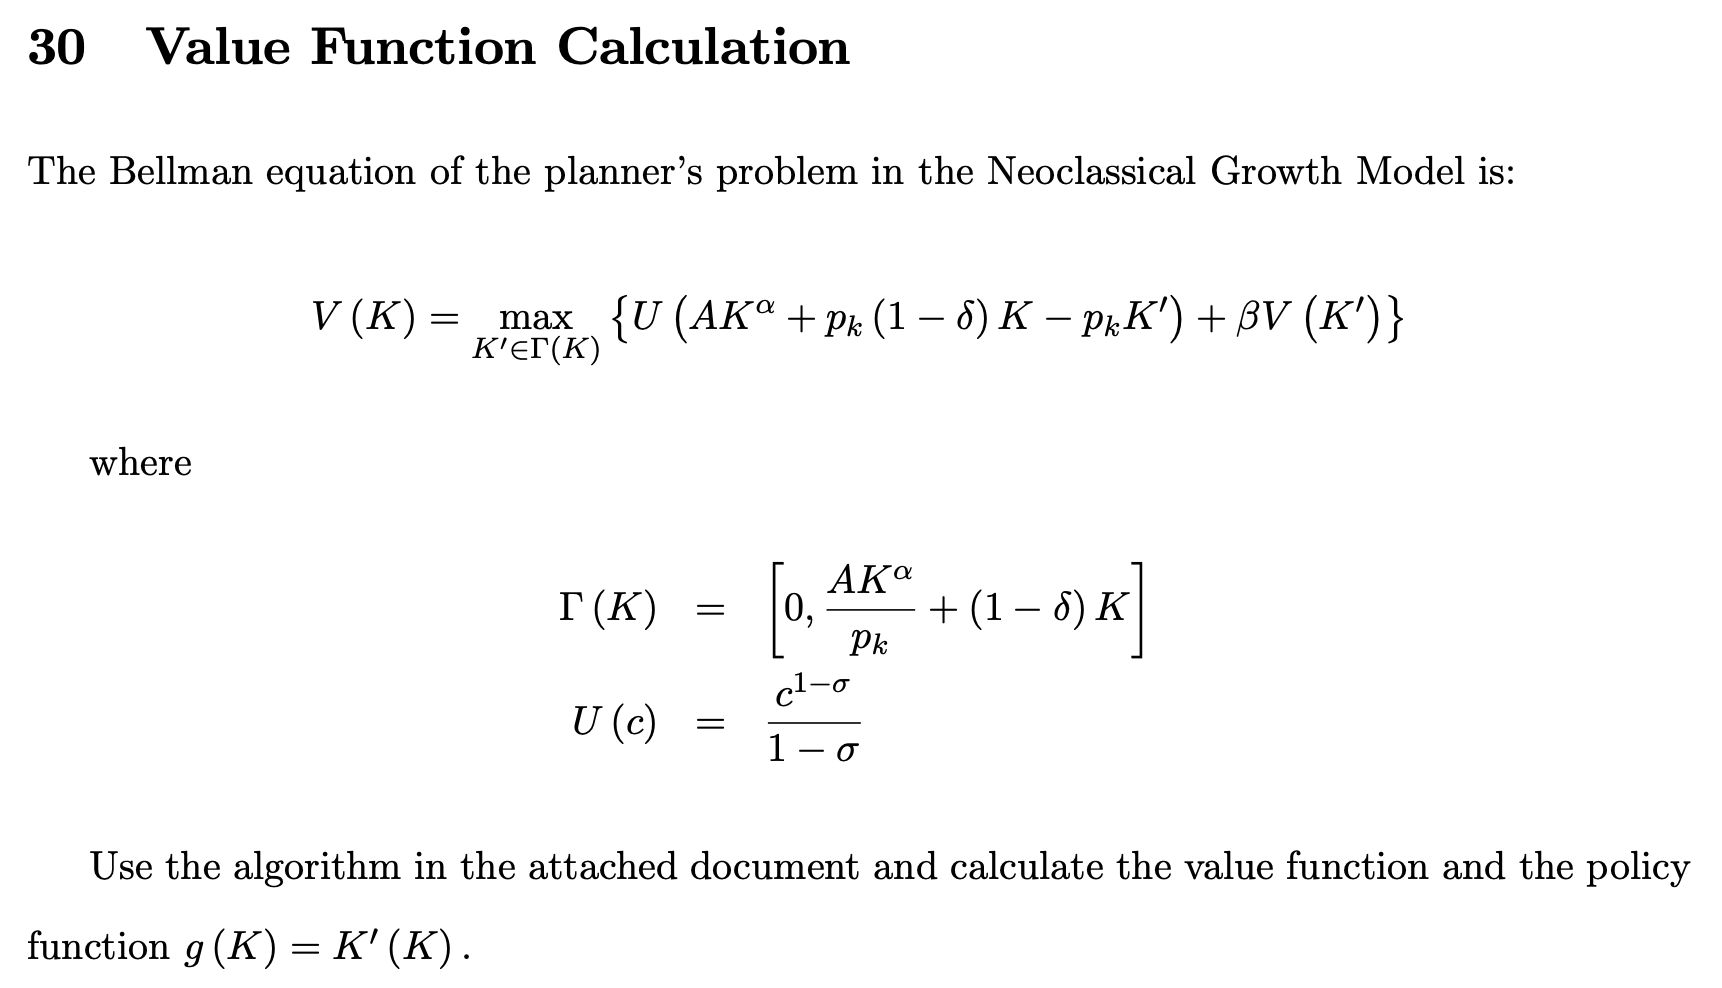

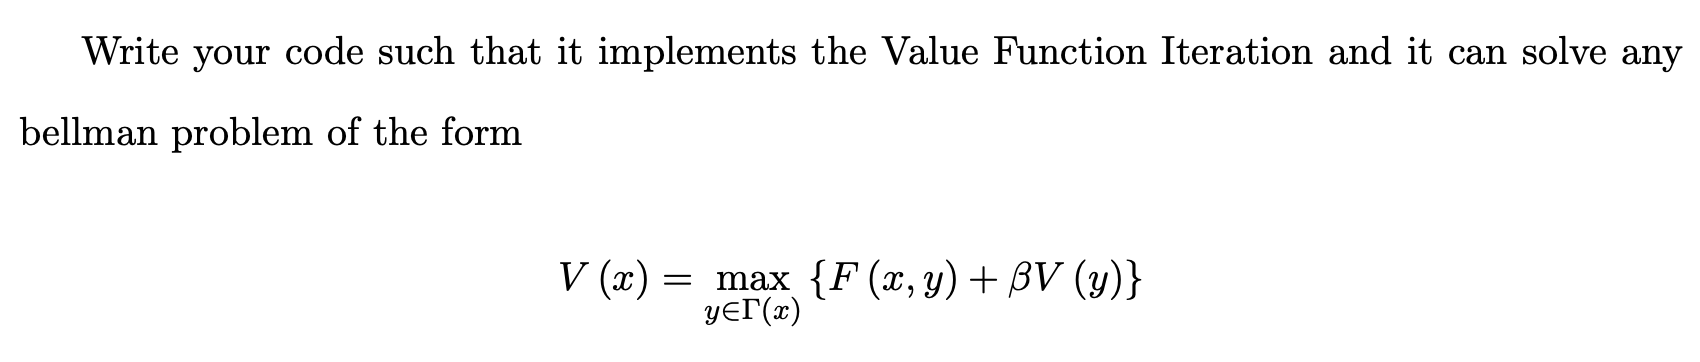

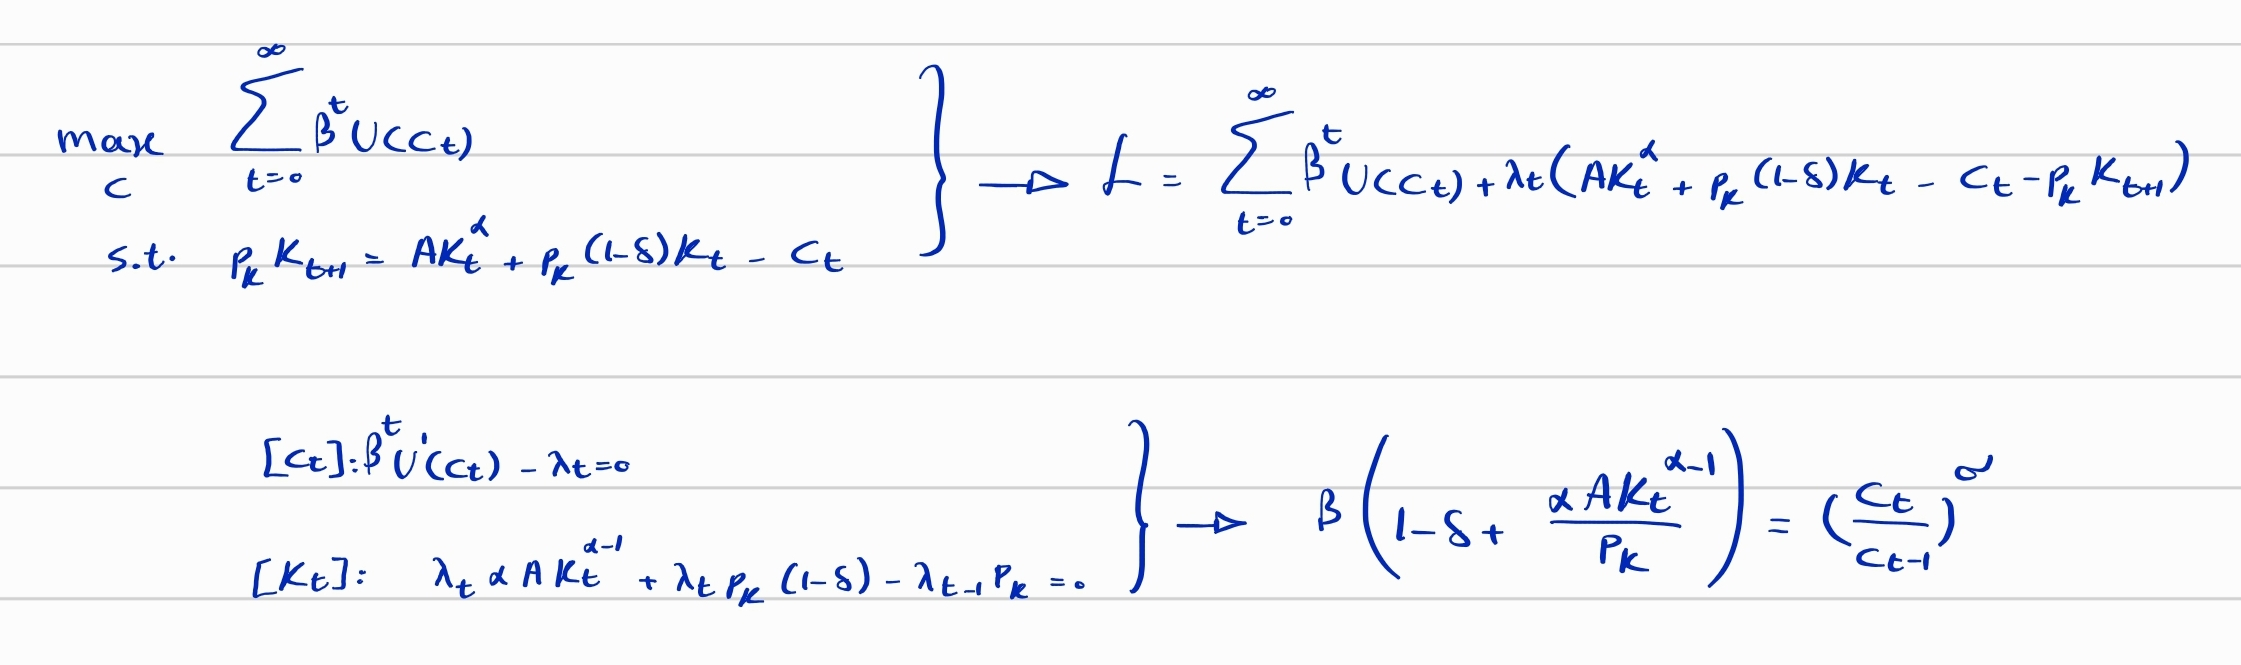

In [1]:
from joblib import Parallel, delayed
import numpy as np
from numpy import interp
from scipy.optimize import fsolve, fminbound
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
# Euler Equ is "1 - delta + alpha * A * K_t ** (alpha - 1) / P_k = (C_t / C_t_pre) ** sigma
alpha, delta, A, p_k, beta, sigma = 0.3, 0.05, 1.0, 1.0, 0.9, 0.5
k_ss = fsolve(func=lambda x: beta * (1 - delta + alpha * A * x[0] ** (alpha - 1) / p_k) - 1, x0=np.array([0.1]))[0]

In [3]:
from numpy import array as np_array 
# Importing increases performance of Parallel!


def value_func_iterate(x_grid, v0_grid, F, T):
    # x=x in lambda!
    # Evaluation Time
    # https://realpython.com/python-lambda/
    y_grid = np_array(Parallel(n_jobs=n_jobs, verbose=0, return_as='list', batch_size=grid_size // n_jobs)(
        delayed(fminbound)(func=lambda y, x=x: -(F(x, y) + beta * interp(y, x_grid, v0_grid)), x1=0, x2=T(x)) for x in
        x_grid))
    v_grid_updated = np_array(F(x_grid, y_grid) + beta * interp(y_grid, x_grid, v0_grid))
    return y_grid, v_grid_updated

## Signle Core

In [4]:
%%time

def U(c):
    return c ** (1 - sigma) / (1 - sigma)


n_jobs = 1
grid_size = 10_000
current_k_grid = np.linspace(0, 2 * k_ss, grid_size)
next_k_grid = np.linspace(0, 2 * k_ss, grid_size)
current_c_grid = A * current_k_grid ** alpha - delta * current_k_grid * p_k
v_grid = U(current_c_grid) / (1 - beta)


max_iter = 1_000
tol = 10 ** -5
for _ in tqdm.tqdm(range(max_iter), ncols=100):
    g, v_grid = value_func_iterate(x_grid=current_k_grid, v0_grid=v_grid,
                                 F=lambda x, y: U(A * x ** alpha + p_k * (1 - delta) * x - p_k * y),
                                 T=lambda x: A * x ** alpha / p_k + (1 - delta) * x)
    err = np.max(np.abs(g - next_k_grid))
    next_k_grid = g
    current_c_grid = A * current_k_grid ** alpha + p_k * (1 - delta) * current_k_grid - p_k * next_k_grid
    if err < tol:
        break

print(f'Solved K_ss ({k_ss}) vs Found K_ss ({current_k_grid[np.argmin(np.abs(current_k_grid[1:] - next_k_grid[1:])) + 1]})')

  2%|█▎                                                           | 21/1000 [00:36<28:33,  1.75s/it]

Solved K_ss (2.430570549152421) vs Found K_ss (2.4303274677893696)
CPU times: user 36.5 s, sys: 2.13 s, total: 38.6 s
Wall time: 36.8 s


## Multi Core

In [5]:
%%time

def U(c):
    return c ** (1 - sigma) / (1 - sigma)


n_jobs = 14
grid_size = 10_000
current_k_grid = np.linspace(0, 2 * k_ss, grid_size)
next_k_grid = np.linspace(0, 2 * k_ss, grid_size)
current_c_grid = A * current_k_grid ** alpha - delta * current_k_grid * p_k
v_grid = U(current_c_grid) / (1 - beta)


max_iter = 1_000
tol = 10 ** -5
for _ in tqdm.tqdm(range(max_iter), ncols=100):
    g, v_grid = value_func_iterate(x_grid=current_k_grid, v0_grid=v_grid,
                                 F=lambda x, y: U(A * x ** alpha + p_k * (1 - delta) * x - p_k * y),
                                 T=lambda x: A * x ** alpha / p_k + (1 - delta) * x)
    err = np.max(np.abs(g - next_k_grid))
    next_k_grid = g
    current_c_grid = A * current_k_grid ** alpha + p_k * (1 - delta) * current_k_grid - p_k * next_k_grid
    if err < tol:
        break

print(f'Solved K_ss ({k_ss}) vs Found K_ss ({current_k_grid[np.argmin(np.abs(current_k_grid[1:] - next_k_grid[1:])) + 1]})')

  2%|█▎                                                           | 21/1000 [00:09<07:03,  2.31it/s]

Solved K_ss (2.430570549152421) vs Found K_ss (2.4303274677893696)
CPU times: user 7.64 s, sys: 602 ms, total: 8.25 s
Wall time: 9.1 s


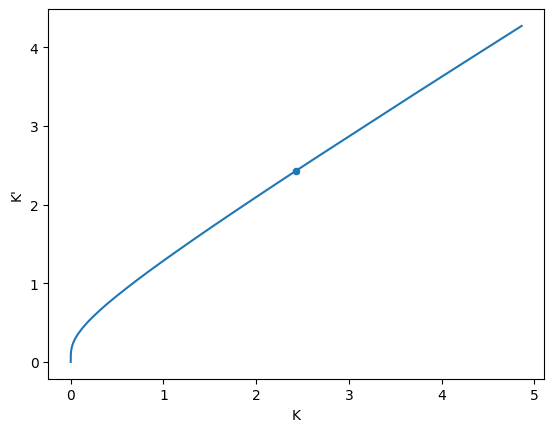

In [6]:
sns.lineplot(x=current_k_grid, y=next_k_grid)
sns.scatterplot(x=[current_k_grid[grid_size//2]], y=[next_k_grid[grid_size//2]])
plt.xlabel('K')
plt.ylabel("K'");